# Evaluate predictions on HotpotQA
- Model predicts weather a sentence is a supporting fact to answer a question
- This notebook rearranges the predictions and evaluates the performance just like the hotpot evaluation script

In [1]:
import random
import math
import os
import pickle
from tqdm import tqdm, trange
import numpy as np

from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import precision_score, recall_score

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

import pdb

In [2]:
from pytorch_pretrained_bert import BertTokenizer

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [4]:
def pickler(path,pkl_name,obj):
    with open(os.path.join(path, pkl_name), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def unpickler(path,pkl_name):
    with open(os.path.join(path, pkl_name) ,'rb') as f:
        obj = pickle.load(f)
    return obj

In [5]:
data_pkl_path = "../../data/hotpot/"
data_pkl_name = "preprocessed_dev.pkl"
predictions_pkl_path = "./"
predictions_pkl_name = "predictions.pkl"

In [6]:
def exact_match(gt, pred):
    assert(len(gt) == len(pred))
    total_size = len(pred)
    num_correct = 0
    for i in range(total_size):
        if(gt[i] == pred[i]):
            num_correct += 1
    return num_correct/total_size

In [7]:
def evaluate(gt, pred):
    assert(len(gt) == len(pred))
    total_size = len(pred)
    assert(len(gt) != 0)
    total_precision = 0
    total_recall = 0
    total_f1 = 0
    total_correct = 0
    for i in trange(total_size):
        if(gt[i] == pred[i]):
            total_correct += 1
        p = precision_score(gt[i], pred[i],average="binary")
        r = recall_score(gt[i], pred[i],average="binary")
        total_precision += p
        total_recall += r
        total_f1 += 2*(p*r)/(p+r) if (p+r)>0 else 0
    return {"precision":total_precision/total_size, "recall":total_recall/total_size, 
            "f1":total_f1/total_size, "em":total_correct/total_size}

In [8]:
def reorganize_predictions(predictions, document_lengths):
    out_list = []
    start_index = 0
    for i in range(len(document_lengths)):
        p = predictions[start_index:start_index+document_lengths[i]]
        out_list.append(p)
        start_index += document_lengths[i]
    return out_list

In [9]:
dataset = unpickler(data_pkl_path, data_pkl_name)

In [10]:
dataset.keys()

dict_keys(['sequences', 'segment_ids', 'supporting_fact', 'document_lengths'])

In [11]:
predictions_raw = unpickler(predictions_pkl_path, predictions_pkl_name)

In [12]:
type(predictions_raw)

numpy.ndarray

In [13]:
predictions_raw.shape

(306423,)

In [14]:
predictions_raw[:20]

array([ -2.703494 ,  -7.3818617,  -9.597219 ,   4.442234 ,  -4.757165 ,
        -2.452815 ,  -5.1548805, -11.324129 , -10.174879 ,  -7.2726355,
        -8.698872 ,  -4.4058604,  -2.4269946,  -6.133337 ,  -5.7811146,
        -3.2419255,   3.4809365,  -9.175812 ,  -9.545071 ,  -7.4124694],
      dtype=float32)

In [15]:
predictions_raw.min()

-18.612978

In [16]:
predictions_raw.max()

9.374624

In [17]:
predictions_raw.mean()

-3.9396749

In [66]:
threshold = 0.9

In [18]:
pred_answer_labels = (torch.sigmoid(torch.tensor(predictions_raw)) > threshold).numpy().tolist()

In [30]:
print(pred_answer_labels[:10])

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


In [20]:
sum(pred_answer_labels)

20152

In [21]:
pred_answer_labels_reorganized = reorganize_predictions(pred_answer_labels, dataset["document_lengths"])

In [22]:
len(pred_answer_labels_reorganized)

7404

In [23]:
gt_reorganized = reorganize_predictions(dataset["supporting_fact"], dataset["document_lengths"])

In [24]:
len(gt_reorganized)

7404

### Are the lengths same ?

In [25]:
for i in range(len(gt_reorganized)):
    assert(len(gt_reorganized[i]) == len(pred_answer_labels_reorganized[i]))

### Evaluation

In [26]:
sum(dataset["supporting_fact"])

18001

In [27]:
sum(pred_answer_labels)

20152

In [28]:
evaluate(gt_reorganized, pred_answer_labels_reorganized)

  0%|          | 0/7404 [00:00<?, ?it/s]/home/bhargav/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
100%|██████████| 7404/7404 [00:13<00:00, 565.50it/s]


{'precision': 0.6867104762921196,
 'recall': 0.7088041213243822,
 'f1': 0.6588673467117654,
 'em': 0.228795245813074}

## Examples of correct and incorrect predictions

In [29]:
import seaborn as sns

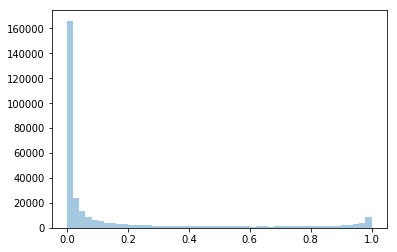

In [43]:
sns.distplot((torch.sigmoid(torch.tensor(predictions_raw))).numpy(),kde=False, hist=True, rug=False)

In [44]:
# for individual question sentence pairs
wrong_prediction_indices = []
correct_prediction_indices = []
for i in range(len(dataset["supporting_fact"])):
    if( dataset["supporting_fact"][i] != pred_answer_labels[i]):
        wrong_prediction_indices.append(i)
    else:
        correct_prediction_indices.append(i)

In [46]:
len(wrong_prediction_indices)

13539

In [47]:
len(correct_prediction_indices)

292884

In [80]:
def get_q_s_pair(index, dataset):
    token_ids = dataset["sequences"][index]
    true_label = dataset["supporting_fact"][index]
    words = tokenizer.convert_ids_to_tokens(token_ids)
    return {"sequence":" ".join(words),"true_label":true_label} 

def sort_indices_increasing_confidence(indices, scores, threshold):
    margins = []
    for index in indices:
        m = scores[index] - threshold
        margins.append(m)
    return np.argsort(np.absolute(margins)), np.absolute(margins)
        

In [57]:
print(get_q_s_pair(wrong_prediction_indices[1], dataset))

{'sequence': '[CLS] what science fantasy young adult series , told in first person , has a set of companion books na ##rra ##ting the stories of enslaved worlds and alien species ? [SEP] with respect to continuity within the series , it takes place before book # 23 , " the pretend ##er " , although the events told in the story occur between the time of " the el ##lim ##ist chronicles " and " the and ##ali ##te chronicles " . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]', 'true_label': 1}


### Least and most confident wrong predictions

In [69]:
sigmoid_scores = (torch.sigmoid(torch.tensor(predictions_raw))).numpy()

In [81]:
incorrect_confidences_sorted, incorrect_margins = sort_indices_increasing_confidence(wrong_prediction_indices, sigmoid_scores, threshold)

In [82]:
print(get_q_s_pair(wrong_prediction_indices[incorrect_confidences_sorted[0]], dataset))
print("margin: ",incorrect_margins[incorrect_confidences_sorted[0]])

{'sequence': '[CLS] which direction do both the m1 and the m ##6 motorway ##s travel ? [SEP] the a1 ##4 is a major road in england , running 127 mi from the port of felix ##sto ##we , suffolk to the cat ##thorpe interchange at the junction of the m1 and m ##6 motorway ##s near rugby , warwickshire . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]', 'true_label': 0}
margin:  9.63211059568092e-06


In [83]:
print(get_q_s_pair(wrong_prediction_indices[incorrect_confidences_sorted[-1]], dataset))
print("margin: ",incorrect_margins[incorrect_confidences_sorted[-1]])

{'sequence': '[CLS] for which film did the director team with nasa scientists , aliens of the deep or poetry in motion ? [SEP] an extended cd - rom version was also released . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]', 'true_label': 1}
margin:  0.8999674147220503


### Least and most confident correct predictions

In [85]:
correct_confidences_sorted, correct_margins = sort_indices_increasing_confidence(correct_prediction_indices, sigmoid_scores, threshold)

In [86]:
print(get_q_s_pair(correct_prediction_indices[correct_confidences_sorted[0]], dataset))
print("margin: ",correct_margins[correct_confidences_sorted[0]])

{'sequence': '[CLS] in which movie the stephanie kay pan ##aba ##ker was alongside with her elder sister danielle nicole pan ##aba ##ker ? [SEP] she is the younger sister of danielle pan ##aba ##ker . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]', 'true_label': 0}
margin:  2.4580955505393298e-05


In [87]:
print(get_q_s_pair(correct_prediction_indices[correct_confidences_sorted[-1]], dataset))
print("margin: ",correct_margins[correct_confidences_sorted[-1]])

{'sequence': '[CLS] what year was the american healthy lifestyle magazine , in which georgia rick ##ard contributed , started ? [SEP] the village has a very healthy sex ratio of 99 ##7 : 1000 , which means villagers do not follow discrimination of a girl from a boy . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]', 'true_label': 0}
margin:  0.8999999917493838
